In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/plant_dataset_split - Copy.zip" -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/plant_dataset_split - Copy/val/Pepper,_bell___healthy/image (1071).JPG  
  inflating: /content/dataset/plant_dataset_split - Copy/val/Pepper,_bell___healthy/image (109).JPG  
  inflating: /content/dataset/plant_dataset_split - Copy/val/Pepper,_bell___healthy/image (1094).JPG  
  inflating: /content/dataset/plant_dataset_split - Copy/val/Pepper,_bell___healthy/image (1108).JPG  
  inflating: /content/dataset/plant_dataset_split - Copy/val/Pepper,_bell___healthy/image (1109).JPG  
  inflating: /content/dataset/plant_dataset_split - Copy/val/Pepper,_bell___healthy/image (112).JPG  
  inflating: /content/dataset/plant_dataset_split - Copy/val/Pepper,_bell___healthy/image (1121).JPG  
  inflating: /content/dataset/plant_dataset_split - Copy/val/Pepper,_bell___healthy/image (1135).JPG  
  inflating: /content/dataset/plant_dataset_split - Copy/val/Pepper,_bell___healthy/image (1137).JPG  
  inflating: /content/da

In [3]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
train_path = '/content/dataset/plant_dataset_split - Copy/train'
val_path = '/content/dataset/plant_dataset_split - Copy/val'
test_path = '/content/dataset/plant_dataset_split - Copy/test'

In [5]:
# Image parameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 64

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 49179 images belonging to 39 classes.
Found 9213 images belonging to 39 classes.
Found 3094 images belonging to 39 classes.


In [6]:
# Get number of classes and class names
NUM_CLASSES = len(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())
print(f"Number of classes: {NUM_CLASSES}")
print(f"Class names: {class_names}")

Number of classes: 39
Class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot'

In [7]:
# Compute class weights for imbalance
class_counts = {}
for class_name in class_names:
    class_path = os.path.join(train_path, class_name)
    class_counts[class_name] = len(os.listdir(class_path))

total_samples = sum(class_counts.values())
class_weights = {train_generator.class_indices[class_name]: total_samples / (NUM_CLASSES * count)
                 for class_name, count in class_counts.items()}
print("Class weights:", class_weights)

Class weights: {0: 1.57625, 1: 1.57625, 2: 1.57625, 3: 0.9582066869300911, 4: 1.3796498905908097, 5: 1.0499583680266444, 6: 1.4994054696789536, 7: 1.57625, 8: 1.57625, 9: 1.323189926547744, 10: 1.57625, 11: 1.3573735199138859, 12: 1.3358050847457628, 13: 1.1401446654611211, 14: 1.466279069767442, 15: 1.57625, 16: 0.2862656072644722, 17: 0.6864452912357104, 18: 1.57625, 19: 1.57625, 20: 1.0668358714043993, 21: 1.57625, 22: 1.57625, 23: 1.57625, 24: 1.57625, 25: 0.3096758349705305, 26: 0.8589918256130791, 27: 1.4216459977452085, 28: 1.57625, 29: 0.7413286302175192, 30: 1.57625, 31: 0.8258022265880812, 32: 1.57625, 33: 0.8905367231638418, 34: 0.941044776119403, 35: 1.1228851291184327, 36: 0.29428238039673277, 37: 1.57625, 38: 0.9913522012578616}


In [9]:
# Build CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 39)             │         5,031 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,199 (641.40 KB)

 Trainable params: 164,199 (641.40 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=180,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-4,verbose=1)
    ],
    verbose=1
)

Epoch 1/180


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


768/768 ━━━━━━━━━━━━━━━━━━━━ 85s 101ms/step - accuracy: 0.0790 - loss: 3.3702 - val_accuracy: 0.2700 - val_loss: 2.3915 - learning_rate: 0.0010
Epoch 2/180
  1/768 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - accuracy: 0.2500 - loss: 2.7453

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


768/768 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.2500 - loss: 2.7453 - val_accuracy: 0.2951 - val_loss: 2.3126 - learning_rate: 0.0010
Epoch 3/180
768/768 ━━━━━━━━━━━━━━━━━━━━ 69s 90ms/step - accuracy: 0.2912 - loss: 2.3361 - val_accuracy: 0.5369 - val_loss: 1.5858 - learning_rate: 0.0010
Epoch 4/180
768/768 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.4062 - loss: 1.8373 - val_accuracy: 0.5403 - val_loss: 1.5698 - learning_rate: 0.0010
Epoch 5/180
768/768 ━━━━━━━━━━━━━━━━━━━━ 82s 102ms/step - accuracy: 0.4533 - loss: 1.8268 - val_accuracy: 0.6155 - val_loss: 1.2585 - learning_rate: 0.0010
Epoch 6/180
768/768 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5625 - loss: 1.5504 - val_accuracy: 0.6240 - val_loss: 1.2313 - learning_rate: 0.0010
Epoch 7/180
768/768 ━━━━━━━━━━━━━━━━━━━━ 142s 115ms/step - accuracy: 0.5505 - loss: 1.4892 - val_accuracy: 0.6703 - val_loss: 1.0598 - learning_rate: 0.0010
Epoch 8/180
768/768 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6250 - loss: 

In [17]:
model.save('/content/drive/My Drive/crop_disease_cnn_95accbatch643lyr001lr05drpoutglobalavgpoolv99final.keras')

In [ ]:
from tensorflow import keras
model = keras.models.load_model(r'C:\Users\vikra\Downloads\proposedmodel\crop_disease_cnn_95accbatch643lyr001lr05drpoutglobalavgpoolv180.keras')

In [18]:
import pickle

with open("/content/drive/MyDrive/historycrop_disease_cnn_95accbatch643lyr001lr05drpoutglobalavgpool_v99final.pkl", "wb") as file:
    pickle.dump(history.history, file)


In [ ]:
with open("/content/drive/MyDrive/historycrop_disease_cnn_95accbatch643lyr001lr05drpoutglobalavgpool_v150.pkl", "rb") as file:
    old_history = pickle.load(file)

# Merge old and new history
for key in old_history.keys():
    history.history[key] = old_history[key] + history.history[key]


In [11]:
# Evaluate on test set
test_generator.reset()
test_loss, test_accuracy = model.evaluate(
    test_generator,
    steps=test_generator.samples // BATCH_SIZE
)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

test_generator.reset()
y_pred = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes[:len(y_pred_classes)]

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.9777 - loss: 0.0704
Test Loss: 0.0903, Test Accuracy: 0.9723
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step
Classification Report:
                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.92      0.94      0.93        50
                            Apple___Black_rot       0.98      1.00      0.99        50
                     Apple___Cedar_apple_rust       0.98      1.00      0.99        50
                              Apple___healthy       0.99      0.98      0.98        83
                    Background_without_leaves       1.00      0.98      0.99        58
                          Blueberry___healthy       0.99      1.00      0.99        76
                      Cherry___Powdery_mildew       0.98      0.98      0.98        54
                             Cherry___healthy       1.00      0.98      0.99        50
   Corn___Cercospora_leaf_spot Gray_le

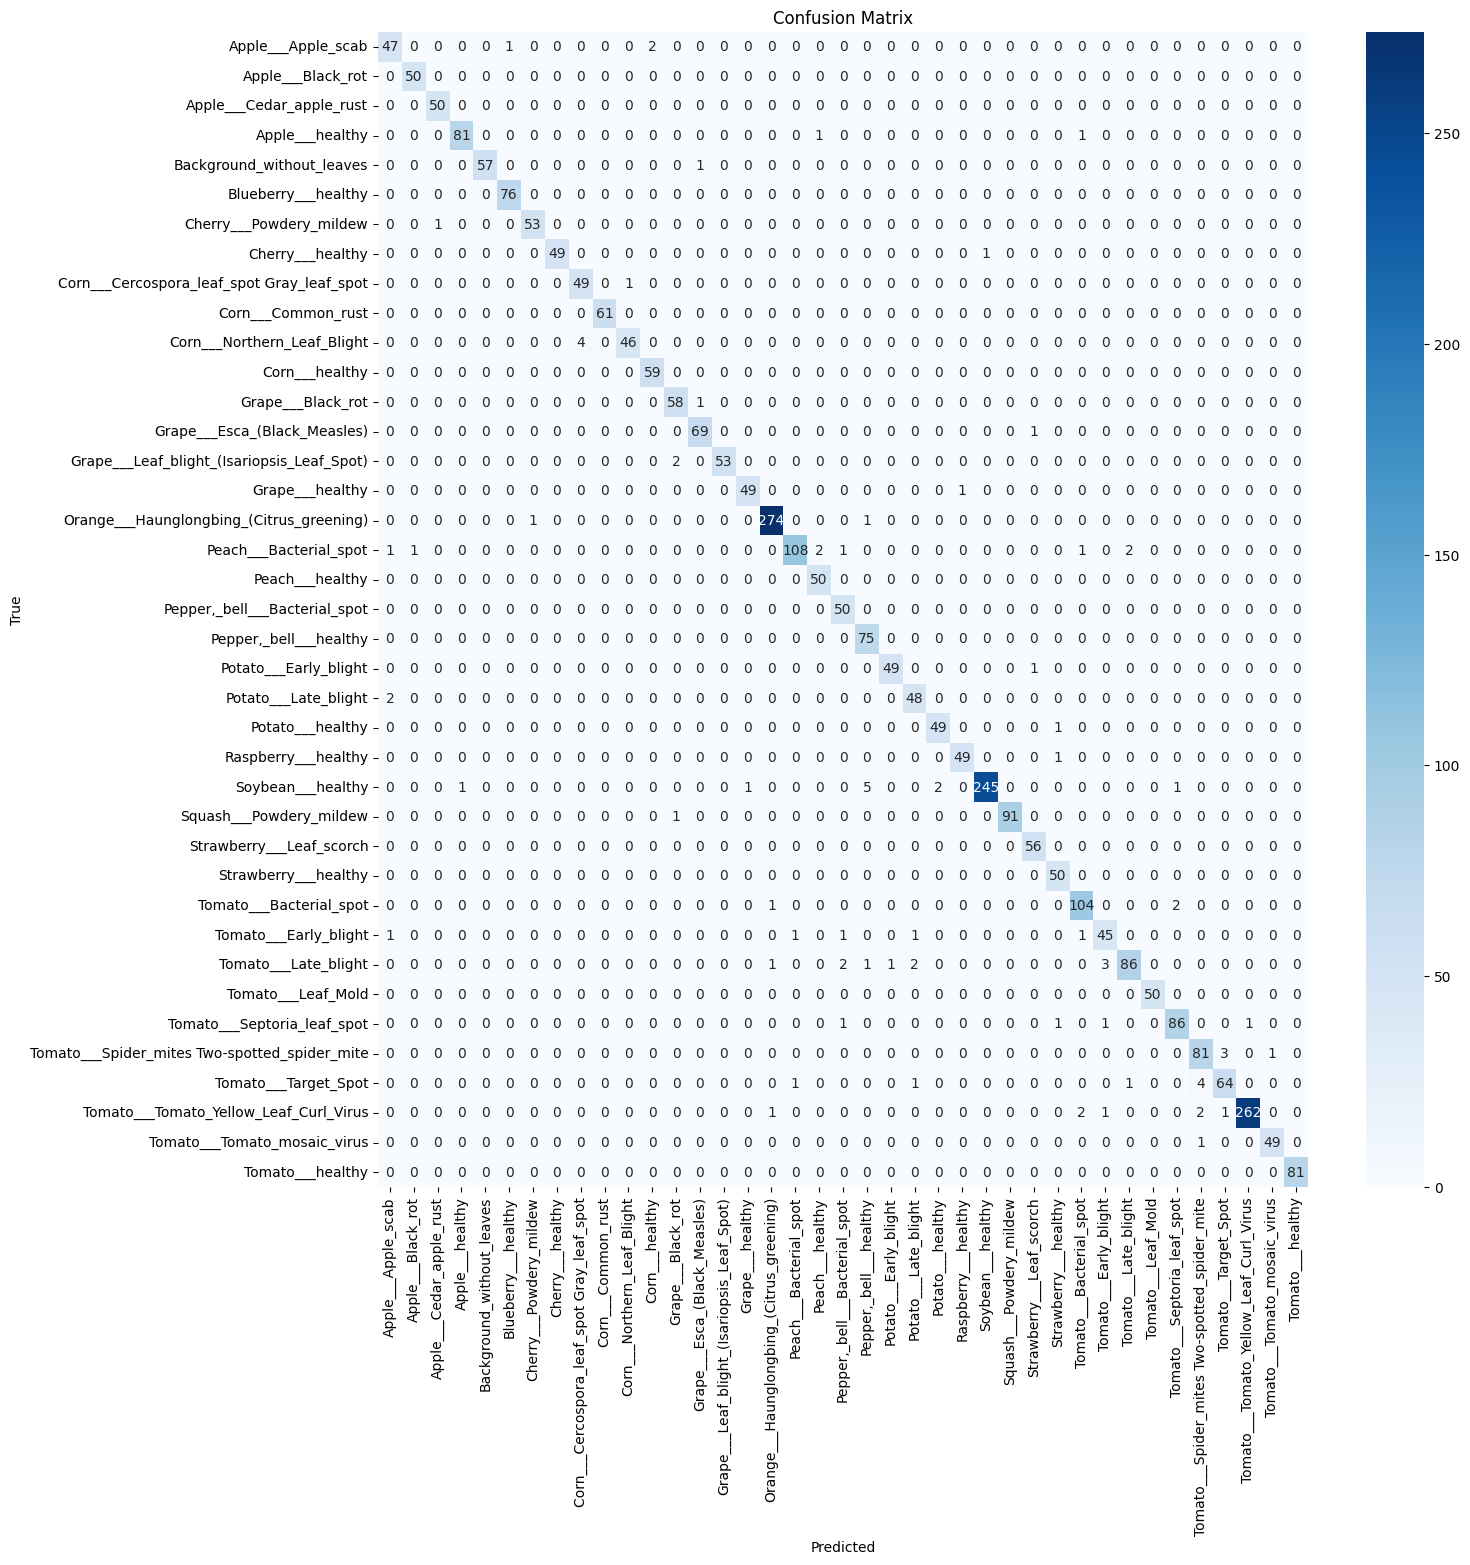

In [14]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



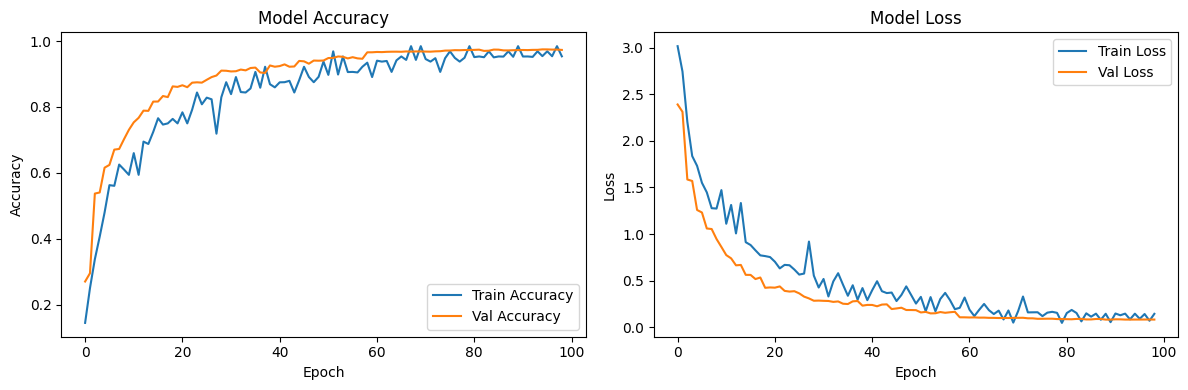

In [15]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

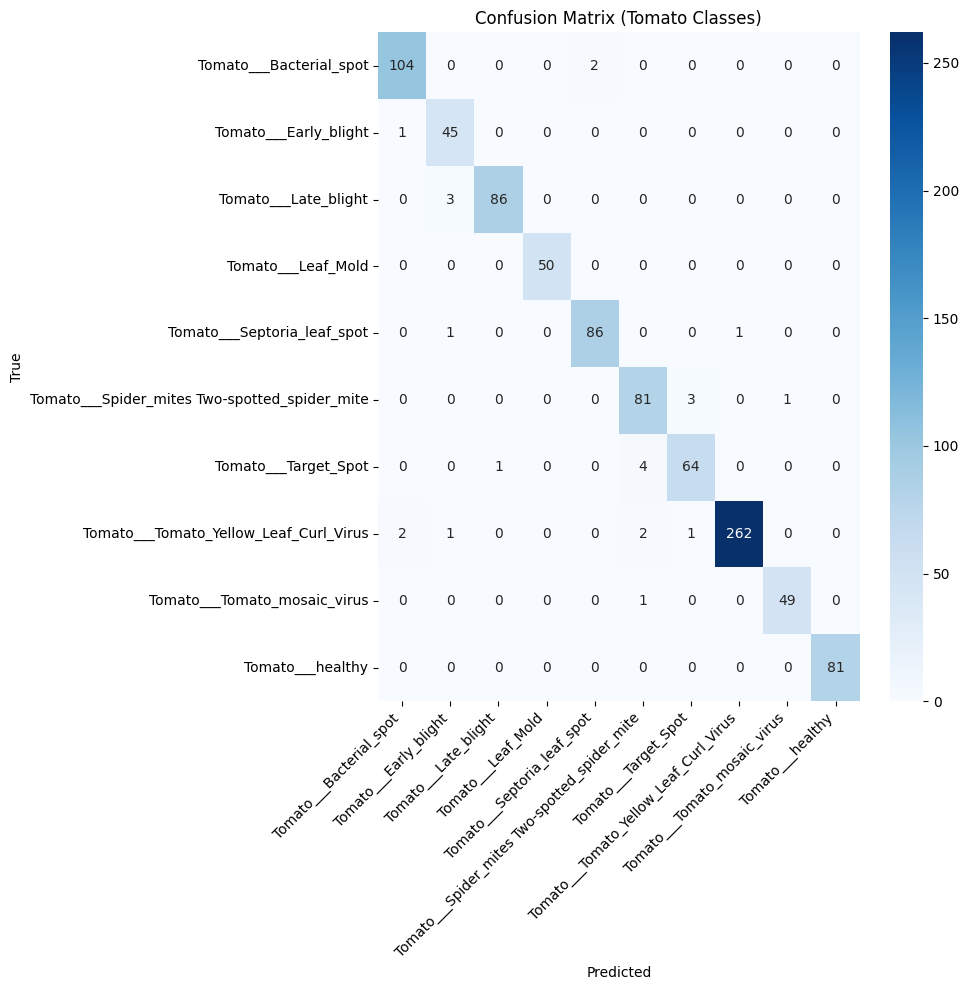

In [16]:
tomato_classes = [i for i, name in enumerate(class_names) if 'Tomato' in name]
cm_tomato = cm[tomato_classes][:, tomato_classes]
class_names_tomato = [class_names[i] for i in tomato_classes]
plt.figure(figsize=(10, 10))
sns.heatmap(cm_tomato, annot=True, fmt='d', cmap='Blues', xticklabels=class_names_tomato, yticklabels=class_names_tomato)
plt.title('Confusion Matrix (Tomato Classes)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

In [20]:
# Get true labels and predictions for test set
test_generator.reset()
y_true = test_generator.classes
y_pred = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)

49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step


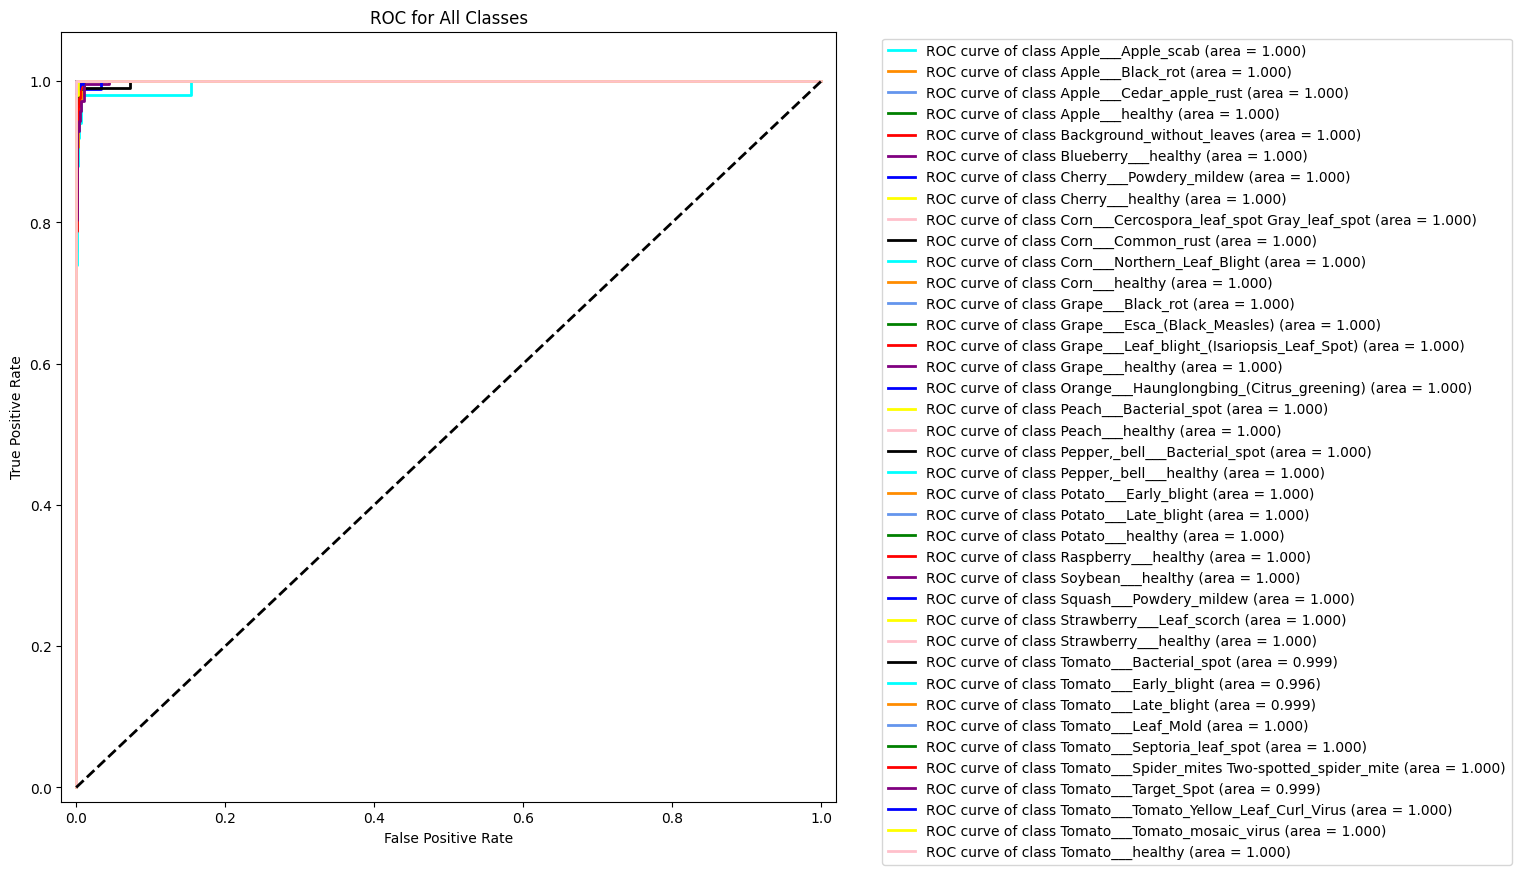

In [21]:
# Binarize the output labels for multi-class ROC
y_true_bin = label_binarize(y_true, classes=np.arange(NUM_CLASSES))
n_classes = y_true_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 10))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red',
                'purple', 'blue', 'yellow', 'pink', 'black'])

for i, color, class_name in zip(range(n_classes), colors, class_names):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.3f})'
             ''.format(class_name, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0 - 0.02, 1.0 + 0.02])
plt.ylim([0.0 - 0.02, 1.05 + 0.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for All Classes')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


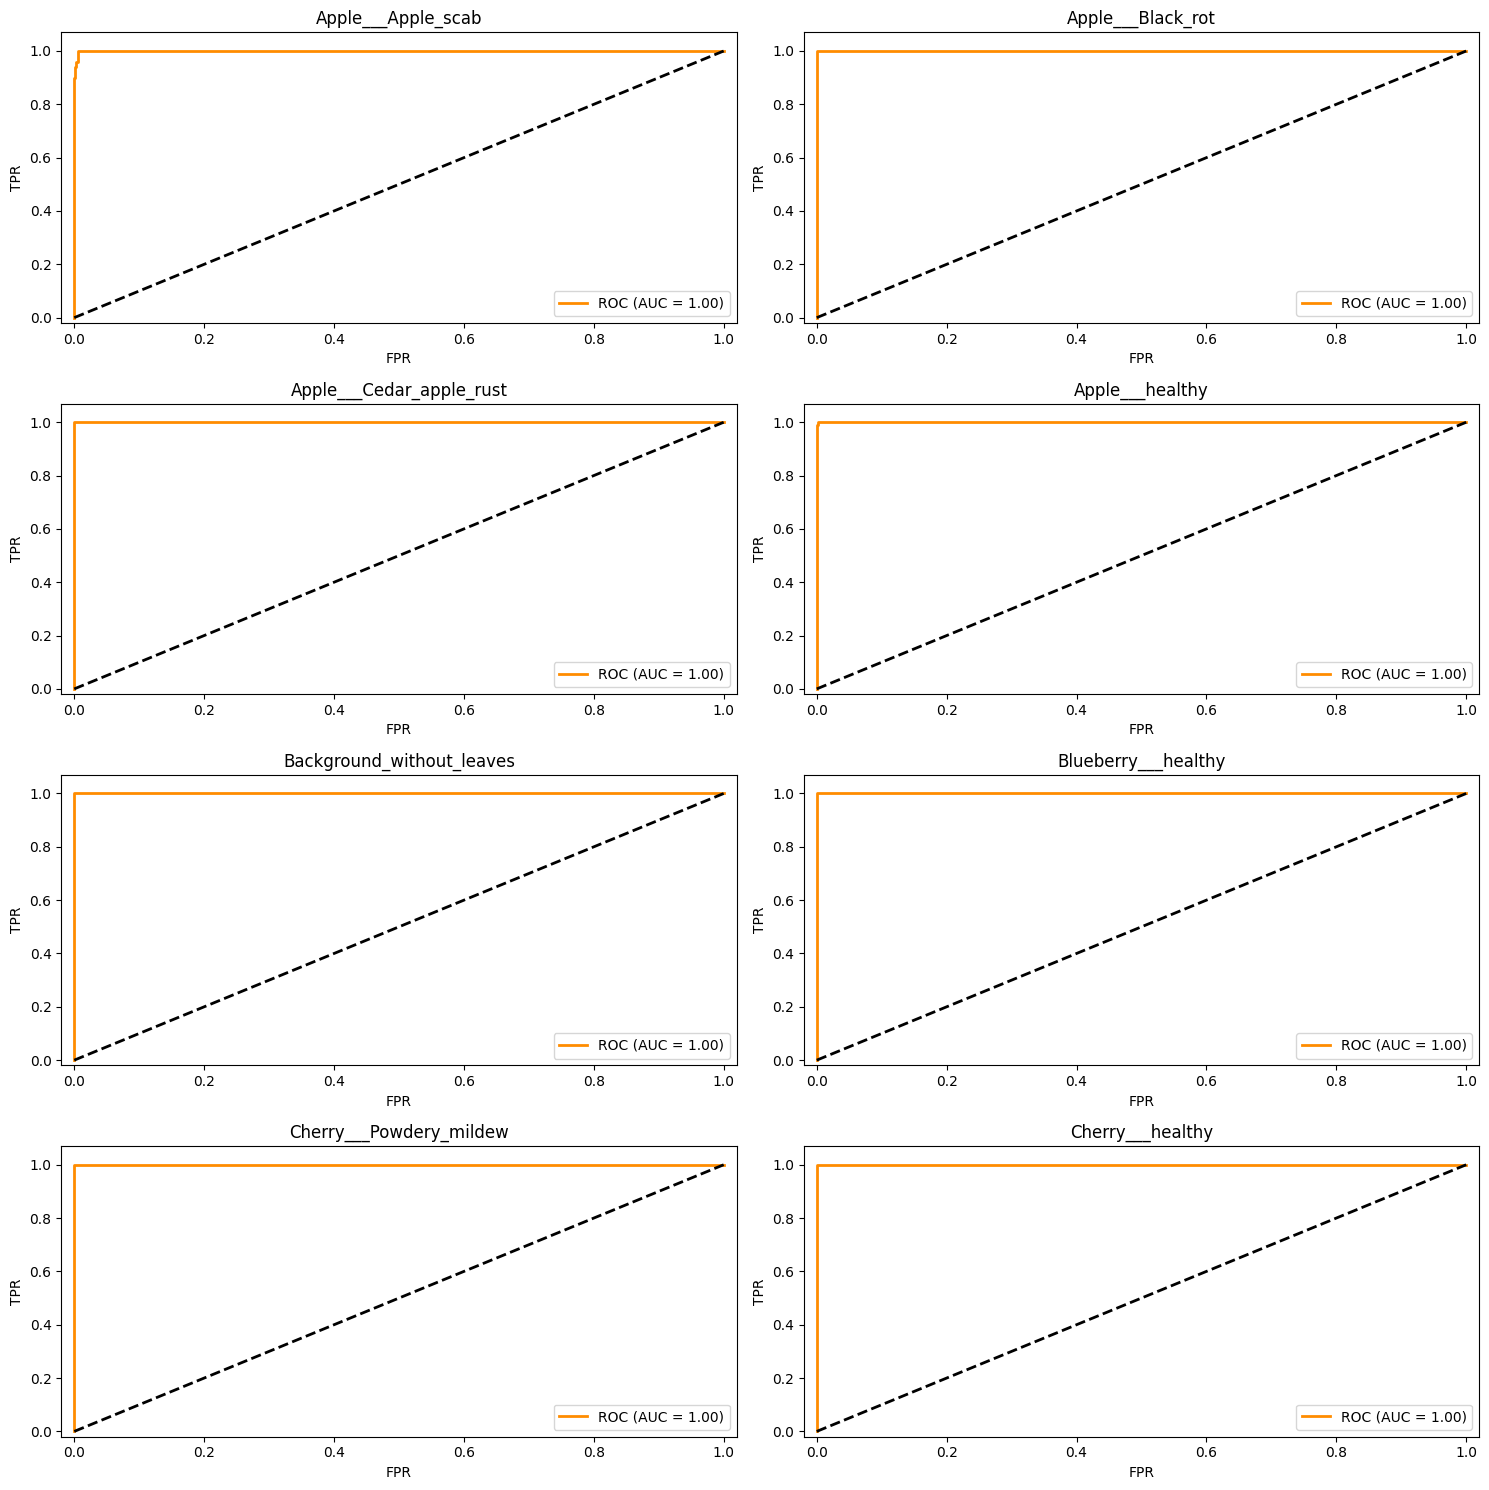

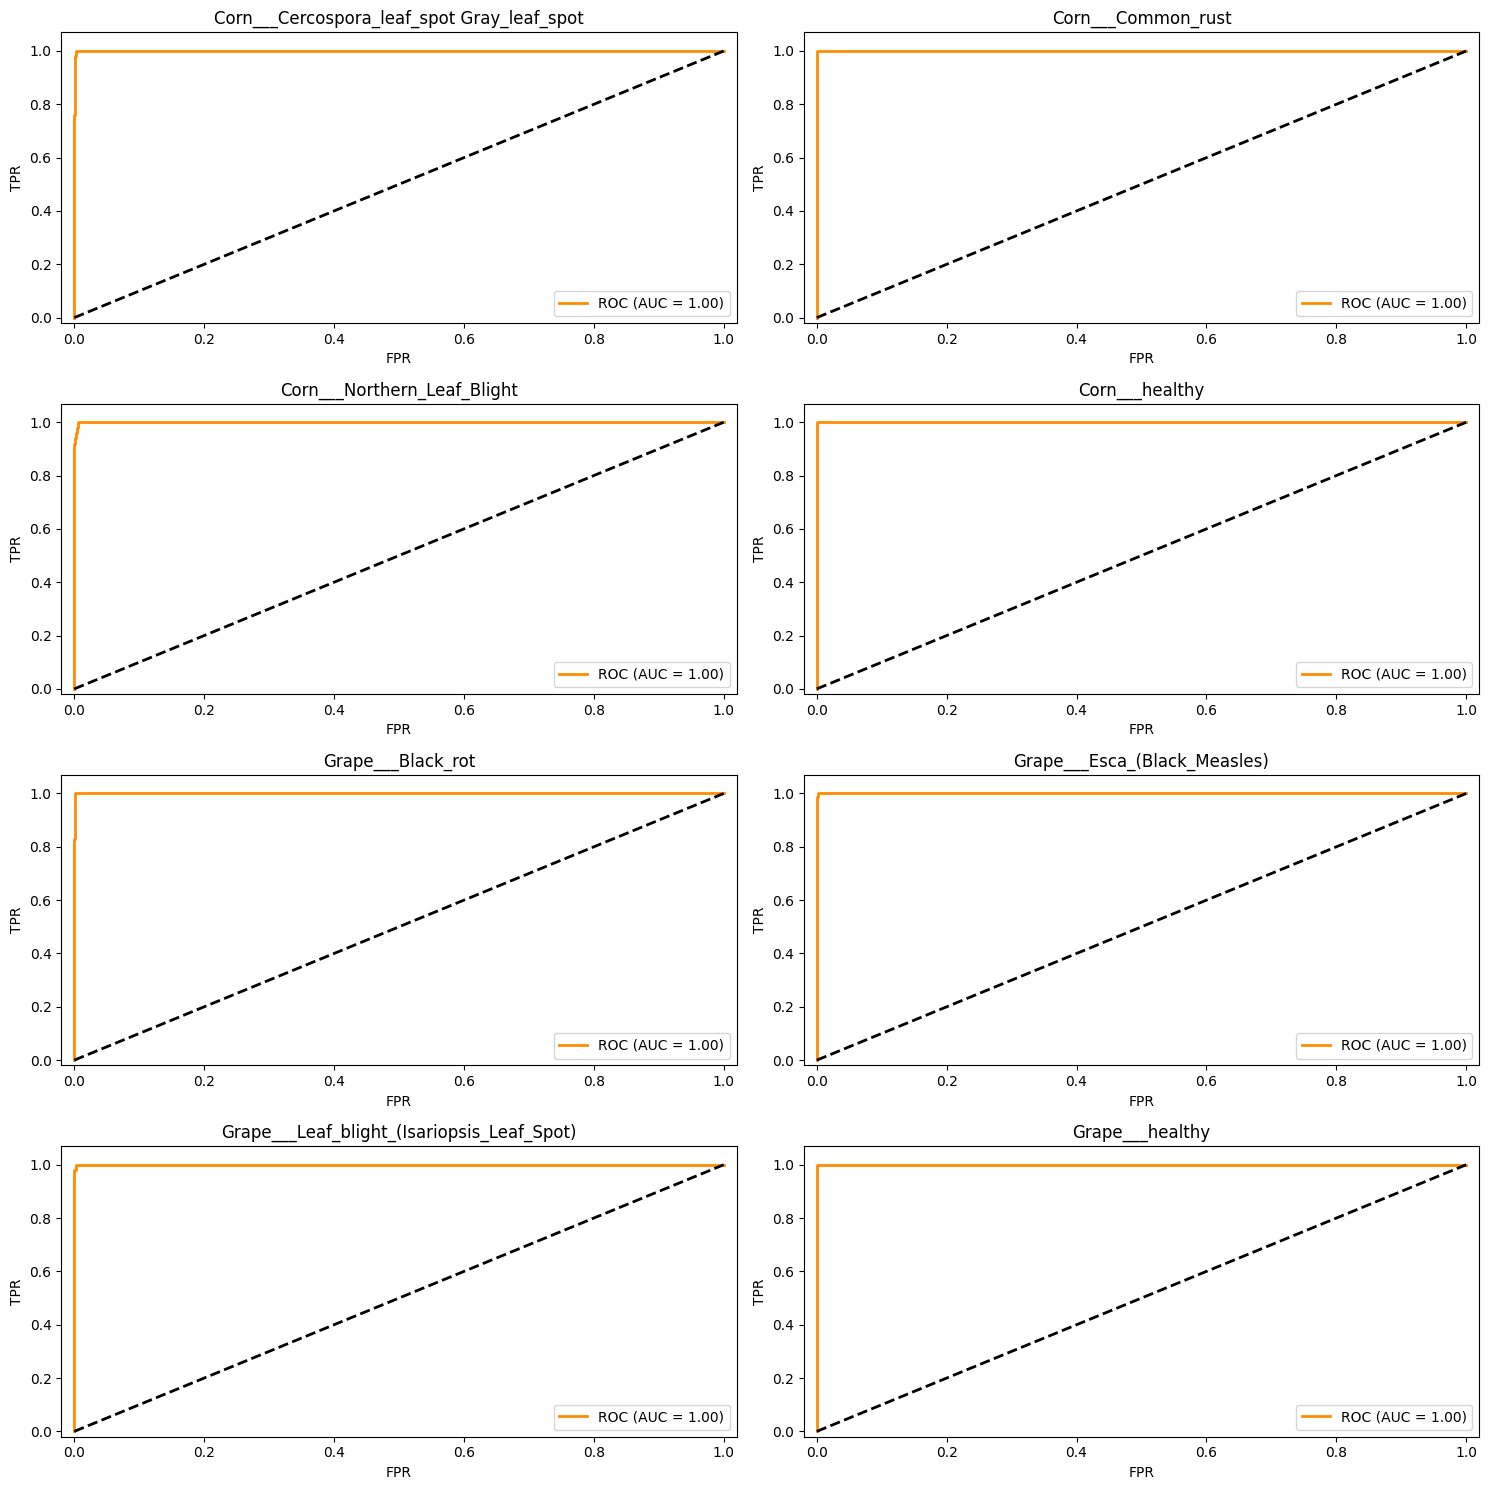

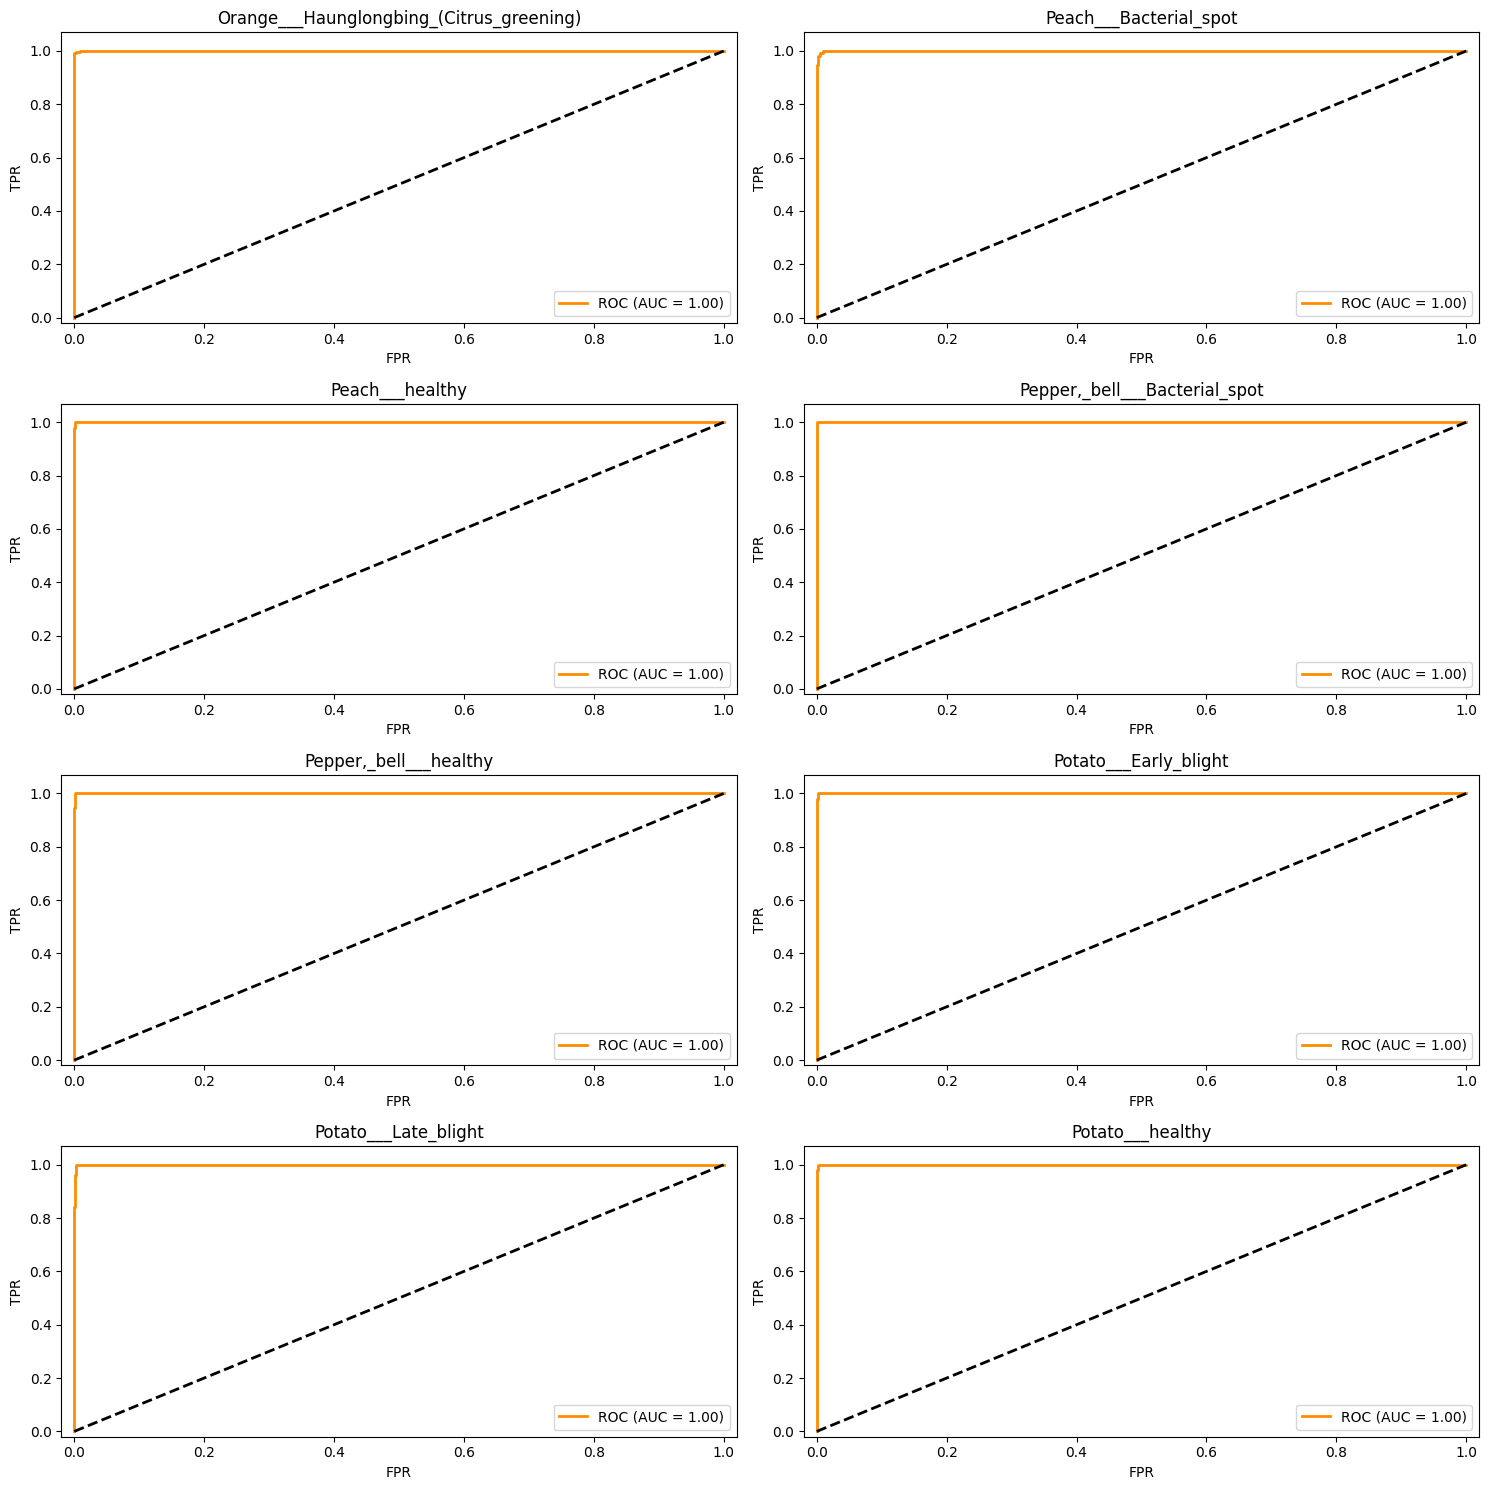

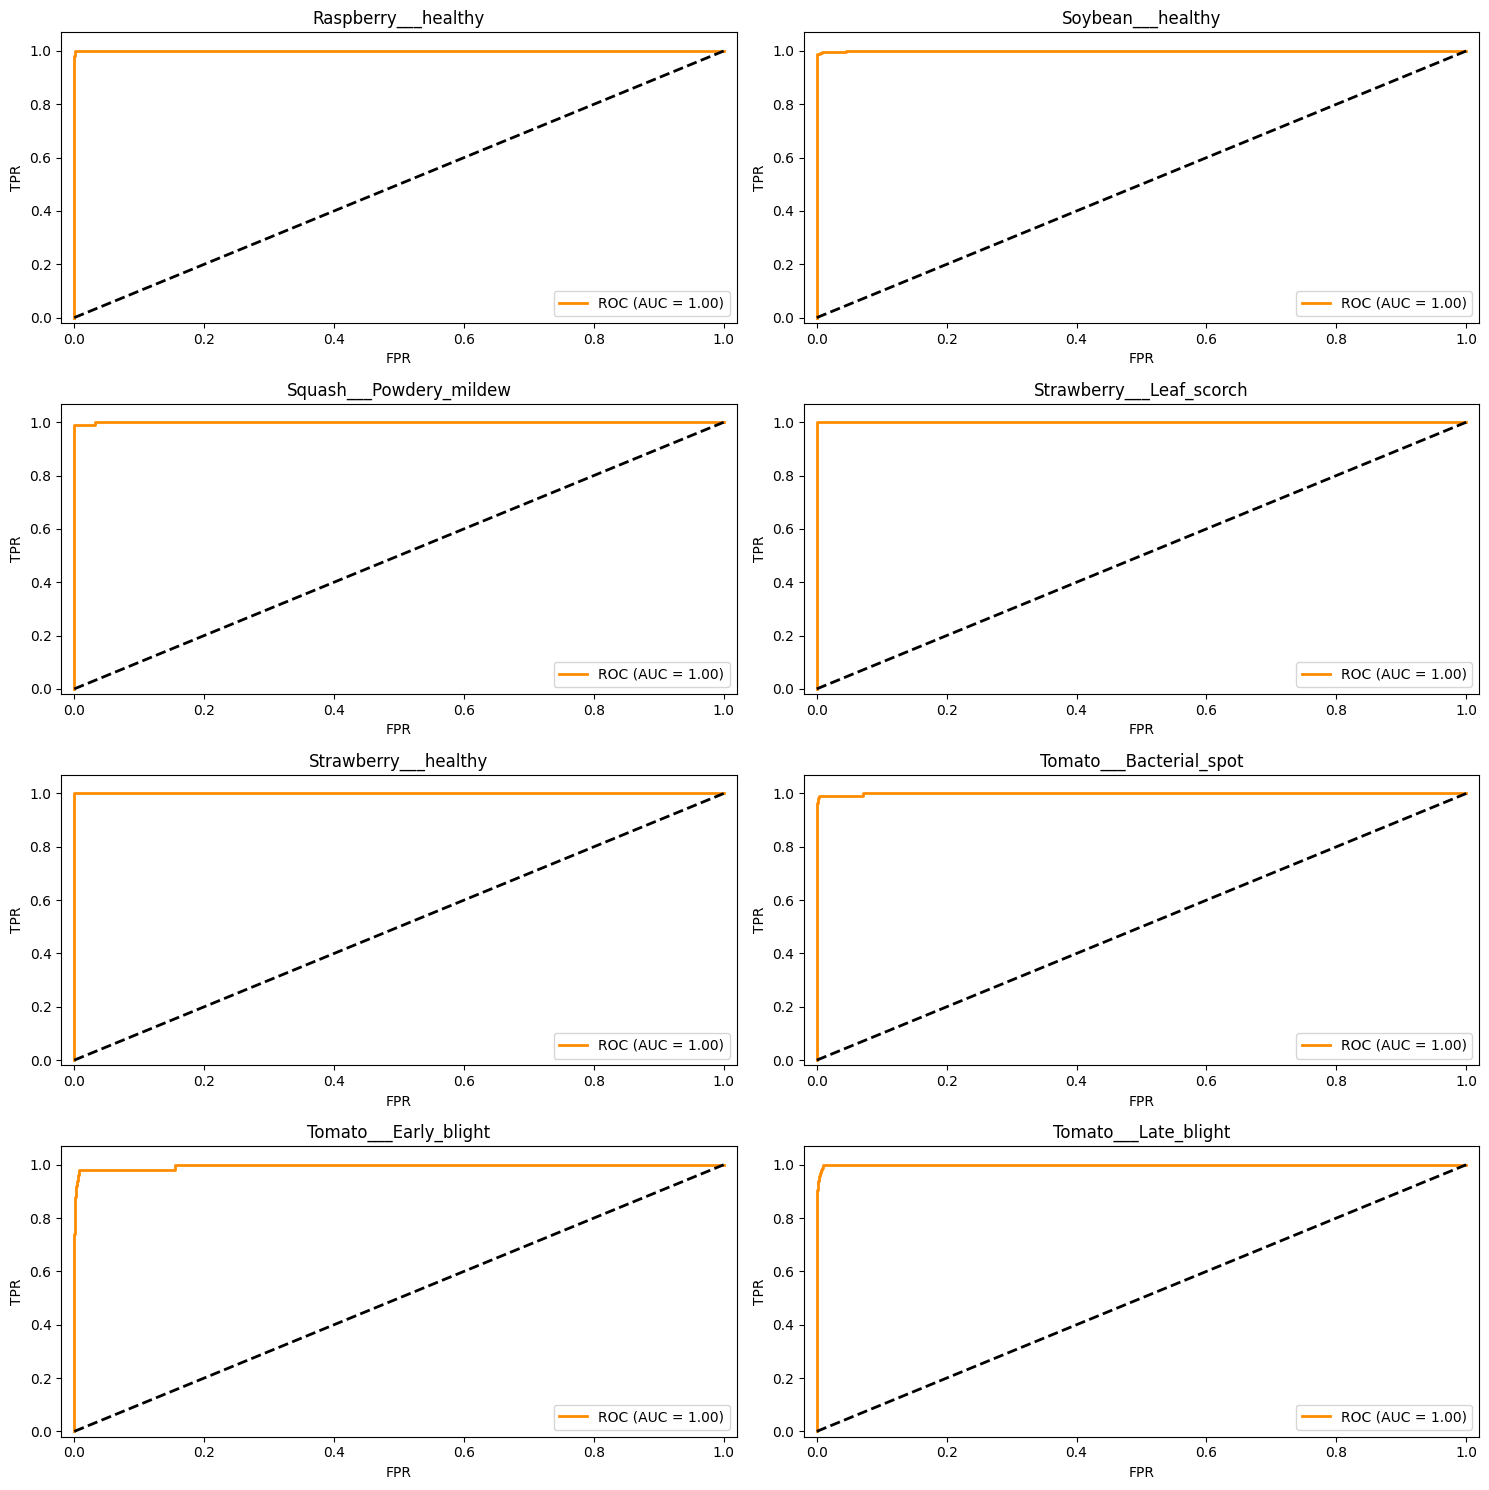

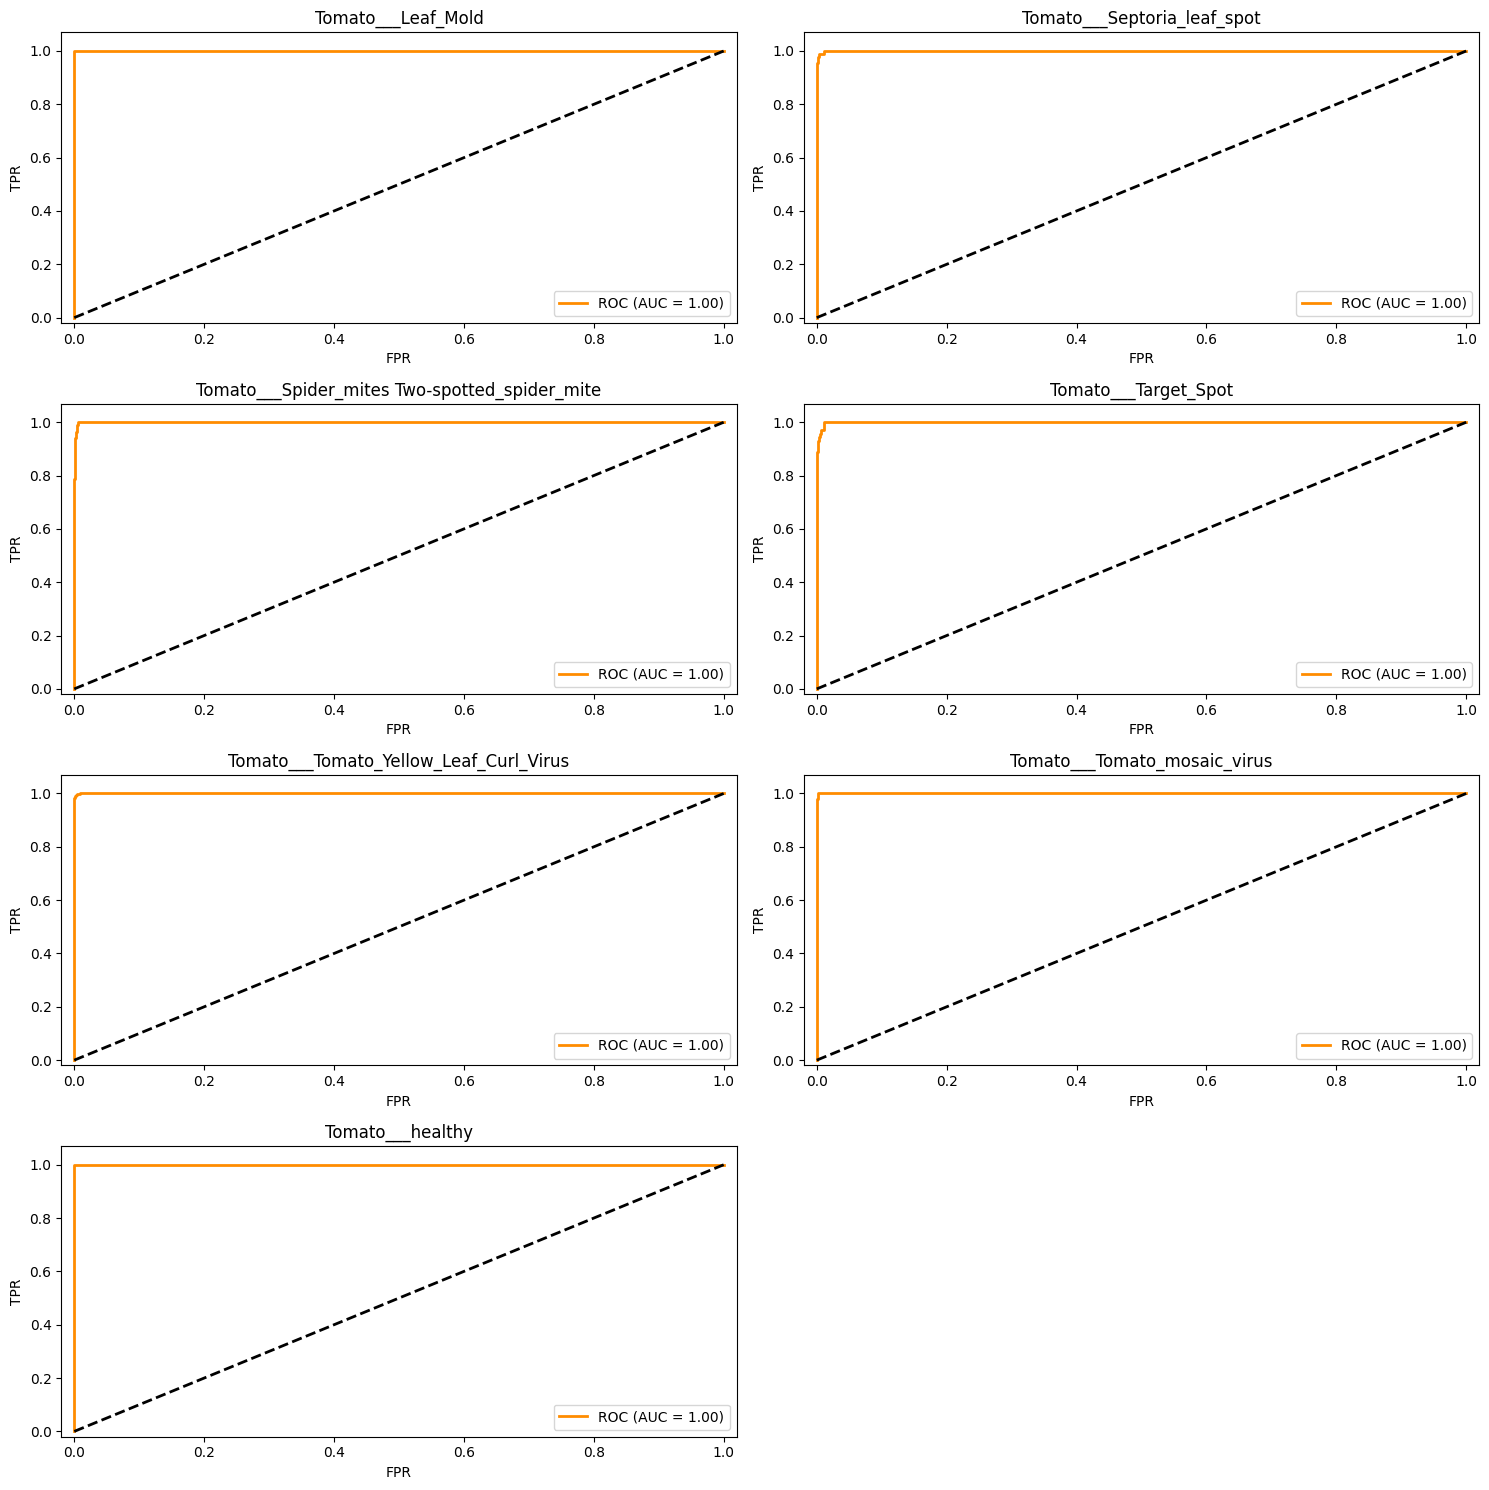

In [23]:
# Binarize the labels
y_true_bin = label_binarize(y_true, classes=np.arange(NUM_CLASSES))

# Calculate ROC for all classes
fpr, tpr, roc_auc = {}, {}, {}
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot individual ROC curves in a grid
plt.figure(figsize=(15, 15))
plot_count = 0
rows = 4
cols = 2
margin = 0.02  # Small margin to offset from axes

for i, class_name in enumerate(class_names):
    if plot_count >= rows*cols:
        plt.tight_layout()
        plt.show()
        plt.figure(figsize=(15, 15))
        plot_count = 0

    plt.subplot(rows, cols, plot_count+1)

    # Plot ROC curve with small offset
    plt.plot(fpr[i], tpr[i], color='darkorange', lw=2,
             label=f'ROC (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    # Set limits with small margin
    plt.xlim([0.0 - margin, 1.0 + margin])
    plt.ylim([0.0 - margin, 1.05 + margin])

    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(class_name)
    plt.legend(loc="lower right")
    plot_count += 1

plt.tight_layout()
plt.show()